# EQ 10.3 does not converge.
## HAH!
### (Except actually it does.)

To determine whether the Equation 10.3. in Stephen Marsland's book *Machine Learning: An Algorithmic Perspective* would lead the probabilistic evolutionary model to converge, Gavin implemented a genetic algorithm in this notebook that generates populations from a string of probabilities.

$$ p = p \times (1 - \eta) + \frac{\eta(\text{best} + \text{second})}{2} $$

After a lengthy, arduous back-and-forth, he discovered that the equation, as stated in the book, does, indeed, contrary to expectations&mdash;converge.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


First we initialise a string of probabilities that represents the optimal gene selection (corresponding to a measure on some task; it is only for the sake of having some optimum).

Then we initialise the string of probabilities on which we begin to learn, along with some other parameters about our population.

In [2]:
true_probability = np.array([1.0, 0.0, 1.0, 0.0, 1.0])
predict_probability = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
max_epoch = 10000
population_size = 3
lr = 0.005
predict_probability_list = np.empty((max_epoch, predict_probability.shape[0]))
error = np.empty(max_epoch)

At each epoch we generate a pool of new individuals from `predict_probability`.

We measure their fitness by comparing their genes to the optimum values (`true_probability`).

We rank the individual according to its fitness.

In [3]:
for epoch in range(10000):
    fst_fit = 1000000
    fst_person = []
    snd_fit = 1000000
    snd_person = []
    
    # Generate and rank individuals.
    for i in range(population_size):
        # Generate an individual.
        person = np.random.rand(predict_probability.shape[0])
        for j in range(predict_probability.shape[0]):
            person[j] = 0.0 if person[j] > predict_probability[j] else 1.0
        
        # Rank its fitness.
        fitness = np.sum(np.abs(true_probability - person))
        if fitness < fst_fit:
            snd_fit = fst_fit
            snd_person = fst_person
            fst_fit = fitness
            fst_person = person
        elif fitness < snd_fit:
            snd_fit = fitness
            snd_person = person
    
    # Adjust the 
    predict_probability = predict_probability * (1 - lr) + lr*(fst_person+snd_person)/2
    predict_probability_list[epoch] = predict_probability
    
    error[epoch] = np.sum(np.abs(true_probability - predict_probability))

Here we compare the change in probabilities `predict_probability` over the epochs.

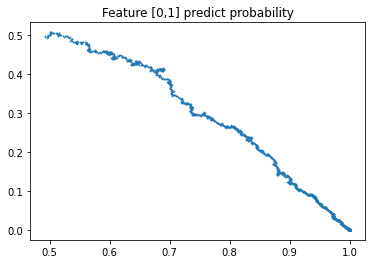

In [4]:
plt.scatter(predict_probability_list[:,0],predict_probability_list[:,1], s=0.5)
plt.title('Feature [0,1] predict probability')
plt.show()

Here we visualise the error over the epochs.

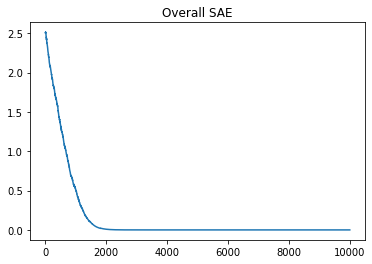

In [5]:
plt.title('Overall SAE')
plt.plot(error)

Q.E.D. we can see that the error diminishes as the algorithm progresses, even though the learning-rate stays constant, therefore it converges.